## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import split_on_value



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.keras.mixed_precision.set_global_policy('mixed_float16')

c:\Users\krist\anaconda3\envs\keras-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Num GPUs Available:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [2]:
tokenizer = pkl.load(open("tokenizers/tokenizer_superQA_24k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>","<pad>"])

In [3]:
def batch(corpus, batch_size=32):
    length = corpus.shape[1]

    batches = length // batch_size

    corpus = corpus[:, :batches * batch_size]

    corpus = tf.reshape(corpus, [-1, batch_size])
    return corpus


In [4]:
corpus_coqa_sqa = pkl.load(open('corpus/corpus_coqa_sqa_24k_padded', 'rb'))
corpus_squad_sqa = pkl.load(open("corpus/corpus_squad_sqa_24k_padded", 'rb'))

corpus_web_qa = pkl.load(open("corpus/corpus_web_qa_24k", 'rb'))
corpus_web_qa = batch(corpus_web_qa, batch_size=768)

corpus_web_article = pkl.load(open("corpus/corpus_web_article_24k", 'rb'))
corpus_web_article = batch(corpus_web_article, batch_size=768)

corpus_wiki_qa = pkl.load(open("corpus/corpus_wiki_qa_24k", 'rb'))
corpus_wiki_qa = batch(corpus_wiki_qa, batch_size=768)

corpus_wiki_article = pkl.load(open("corpus/corpus_wiki_article_24k", 'rb'))
corpus_wiki_article = batch(corpus_wiki_article, batch_size=768)


In [5]:
print(corpus_coqa_sqa.shape)
print(corpus_squad_sqa.shape)
print(corpus_web_qa.shape)
print(corpus_web_article.shape)
print(corpus_wiki_qa.shape)
print(corpus_wiki_article.shape)

(7199, 768)
(19035, 768)
(2495, 768)
(21710, 768)
(2026, 768)
(26420, 768)


In [13]:
print(np.sum(corpus_coqa_sqa[:100]==-1))
print(np.sum(corpus_squad_sqa[:100]==-1))
print(np.sum(corpus_web_qa[:100]==-1))
print(np.sum(corpus_web_article[:100]==-1))
print(np.sum(corpus_wiki_qa[:100]==-1))
print(np.sum(corpus_wiki_article[:100]==-1))

0
0
0
0
0
0


In [6]:
corpus = tf.concat([corpus_coqa_sqa, corpus_squad_sqa, corpus_web_qa, corpus_web_article, corpus_wiki_qa, corpus_wiki_article], axis=0)

tf.random.set_seed(42)
corpus = tf.random.shuffle(corpus)
length = corpus.shape[0]
ratio = int(length * 0.95)

corpus_train = corpus[:ratio] 
corpus_test = corpus[ratio:]

print(length*768)

60583680


In [7]:
def data_pipeline(corpus, batch_size=32):
    samples = corpus.shape[0]

    steps_per_epoch = samples // batch_size
    
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=100*batch_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    
    return ds, steps_per_epoch

In [16]:
ds_train, steps_per_epoch = data_pipeline(corpus_train, batch_size=5)
ds_test,_ = data_pipeline(corpus_test, batch_size=2)

## Define Model

In [4]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 768
embed_dim = 896
tf_blocks = 14
heads = 14
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []
accum_steps = 10

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    accum_steps=accum_steps,
                    )

losses_train = []
losses_test = []


In [5]:
name = "model_super_qa_larger"

ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [6]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [8]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")
print(model.accum_steps)

Total number of parameters: 157298091
tf.Tensor(10, shape=(), dtype=int32)


In [12]:
def train_loop(iter_train, iter_test, steps_per_epoch, epochs):
    for i in tqdm(range(steps_per_epoch//accum_steps*epochs)):
        loss_train_temp = 0
        loss_test_temp = 0
        for _ in range(accum_steps):
            batch_train = next(iter_train)
            batch_test = next(iter_test)
            
            loss_train_temp += model.train_step(batch_train).numpy()
            
        loss_test_temp = model.evaluate(batch_test).numpy()
            
        loss_train_temp /= accum_steps
        losses_train.append(loss_train_temp)
        losses_test.append(loss_test_temp)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

    
        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(f"Step {i+1}, Loss Train: {loss_train_temp:.4f}, Loss Test: {loss_test_temp:.4f}, LR: {lr:.6f}")
    ckpt_manager.save()
    pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))
    return losses_train, losses_test

In [22]:
iter_train = iter(ds_train)
iter_test = iter(ds_test)

In [986]:
train_loop(iter_train, iter_test, steps_per_epoch, 4)

  0%|          | 0/5992 [00:00<?, ?it/s]

Step 1, Loss Train: 3.0538, Loss Test: 3.9885, LR: 0.000031
Step 2, Loss Train: 2.9546, Loss Test: 3.4908, LR: 0.000031
Step 3, Loss Train: 3.0938, Loss Test: 3.9962, LR: 0.000031
Step 4, Loss Train: 3.0038, Loss Test: 4.1693, LR: 0.000031
Step 5, Loss Train: 2.9154, Loss Test: 2.5450, LR: 0.000031
Step 6, Loss Train: 2.9208, Loss Test: 4.0887, LR: 0.000031
Step 7, Loss Train: 3.0034, Loss Test: 3.8552, LR: 0.000031
Step 8, Loss Train: 2.8440, Loss Test: 4.3759, LR: 0.000031
Step 9, Loss Train: 3.1054, Loss Test: 3.8763, LR: 0.000031
Step 10, Loss Train: 2.7316, Loss Test: 4.4927, LR: 0.000031
Step 11, Loss Train: 2.9994, Loss Test: 3.1807, LR: 0.000031
Step 12, Loss Train: 3.1585, Loss Test: 3.9829, LR: 0.000031
Step 13, Loss Train: 2.9909, Loss Test: 4.1398, LR: 0.000031
Step 14, Loss Train: 3.1708, Loss Test: 3.9126, LR: 0.000031
Step 15, Loss Train: 3.0113, Loss Test: 4.5229, LR: 0.000031
Step 16, Loss Train: 2.9962, Loss Test: 3.8865, LR: 0.000031
Step 17, Loss Train: 2.9627, Loss

([14.869240283966064,
  14.843252420425415,
  14.892844319343567,
  14.80180025100708,
  14.724263310432434,
  14.663204073905945,
  14.5652015209198,
  14.610636353492737,
  14.481077671051025,
  14.371236801147461,
  14.16866409778595,
  14.179565668106079,
  13.955062866210938,
  13.723238348960876,
  13.687171220779419,
  13.42956829071045,
  13.270652055740356,
  13.215447545051575,
  12.976373434066772,
  12.854222774505615,
  12.749372601509094,
  12.356987118721008,
  12.408194184303284,
  12.012135982513428,
  11.96212911605835,
  11.955255627632141,
  11.720670461654663,
  11.728261590003967,
  11.652526021003723,
  11.41602349281311,
  11.378599643707275,
  11.379032373428345,
  11.259947061538696,
  11.20085597038269,
  11.081208109855652,
  11.026306986808777,
  10.874039649963379,
  10.795849680900574,
  10.749486804008484,
  10.714420795440674,
  10.663718104362488,
  10.72929573059082,
  10.490420460700989,
  10.387823343276978,
  10.372750401496887,
  10.35437428951263

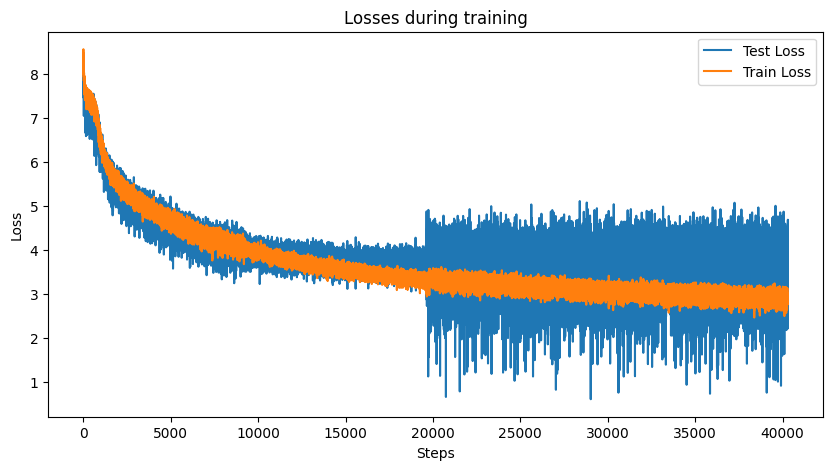

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(losses_test[100:], label="Test Loss")
plt.plot(losses_train[100:], label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during training")
plt.legend()
plt.show()

In [902]:
text = "<s>John is in the house. Sarah is in the garden.<q> Where is John?"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)

In [ ]:
import textwrap
import ipywidgets as widgets
from IPython.display import display, HTML

display(HTML("""
<style>
.widget-textarea textarea {
    background-color: #2e2e2e !important;
    color: #f1f1f1 !important;
    border: 1px solid #555 !important;
}
</style>
"""))

wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

text = "<s>Link "
#text = "<s>John is in the house. Sarah is in the garden.<q>Where is John?"
#text = "<s>The apple is green. The banana is yellow. The tomato is red.<q> What color is the banana?"
#text = "<s>The apple is green. The banana is yellow. The tomato is red.<q> What color is the banana?"
#text = "<s><q>Who is Midna?<a>"
#text = "<s><q>Name two presidents?<a>"
#text = "<s><q>name two presidents?<a>george washington (1789-1832) and john adams.<q>tell me more about john adams.<a>"
#text = "<s>Fred went to school. Then he went to church. Then he went home.<q>Where did Fred go after school?<a>"
#text = "<s><q>Name a famous dictator.<a>"
#text = "<s><q>Give me a long answer?<a>"
#text = "<s><q>Who is the vocalist of coldplay?<a>"
#text = "<s>cnn"
#text = "<s><q>Why was hitler bad?<a>"
#text = "<s><q>Name many colors?<a>"
#text = "<s><q>Name a leader?<a>"
#text = "<s><q>Name an illness?<a>police poisoning<q>what is that?<a>"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)

T = 1
k = 50


for i in range(1024):
    logits = model.call(tokens)[0, -1:]
    topk_vals, _      = tf.math.top_k(logits, k=k)
    kth_value         = topk_vals[:,-1]

    logits = tf.where(logits >= kth_value, logits, tf.constant(-np.inf, logits.dtype))

    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    ) 
    tokens = tf.concat([tokens, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(tokens)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:# or idx[0, 0] == tokenizer.token_to_idx["<q>"]:
        break

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

KeyboardInterrupt: 